# AIS Spoofing Evaluation Notebook

This notebook runs both single-trajectory evaluations and population-level test-set evaluations using the augmented AIS dataset.

## 1. Setup Dependencies and Paths
Install/import required libraries, set data/model paths, and configure device.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
# project_root = Path(__file__).resolve().parent
project_root = Path("./dataset/")
# data_root = project_root / ".." / "dataset" / "piraeus"
output_root = project_root / "models"
output_root.mkdir(parents=True, exist_ok=True)
# augmented_path = data_root / "ais_augmented.parquet"
augmented_path = Path("./dataset/ais_augmented.parquet")

# print(f"Data root: {data_root}")
print(f"Output root: {output_root}")
print(f"Augmented dataset: {augmented_path}")

Using device: cuda
Output root: dataset\models
Augmented dataset: dataset\ais_augmented.parquet


## 2. Load Augmented Test Dataset
Load the augmented AIS dataset created from train.ipynb for evaluation.

In [2]:
if not augmented_path.exists():
    raise FileNotFoundError(
        f"Augmented dataset not found at {augmented_path}. Run train.ipynb first to generate it."
    )

print(f"Loading augmented dataset from: {augmented_path}")
ais_augmented = pd.read_parquet(augmented_path)

# Basic stats
total = len(ais_augmented)
genuine = int((ais_augmented['is_spoofed'] == 0).sum())
spoofed = total - genuine
print("Loaded Augmented Dataset Statistics:")
print(f"  Total records: {total:,}")
print(f"  Genuine: {genuine:,} ({genuine/total*100:.1f}%)")
print(f"  Spoofed: {spoofed:,} ({spoofed/total*100:.1f}%)")
print(f"  Unique vessels: {ais_augmented['vessel_id'].nunique()}")
print(f"  Time range: {ais_augmented['timestamp'].min()} to {ais_augmented['timestamp'].max()}")

Loading augmented dataset from: dataset\ais_augmented.parquet
Loaded Augmented Dataset Statistics:
  Total records: 38,307,951
  Genuine: 35,158,721 (91.8%)
  Spoofed: 3,149,230 (8.2%)
  Unique vessels: 4260
  Time range: 2017-07-31 21:00:00+00:00 to 2019-11-27 07:23:48+00:00


## 3. Load Model and Weights
Define the Bi-LSTM model, load saved weights and scaler, and switch to eval mode.

In [3]:
import pickle

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, lstm_units_1=62, lstm_units_2=30):
        super().__init__()
        self.bilstm1 = nn.LSTM(input_size=input_size, hidden_size=lstm_units_1,
                               batch_first=True, bidirectional=True, dropout=0.2)
        self.bilstm2 = nn.LSTM(input_size=lstm_units_1*2, hidden_size=lstm_units_2,
                               batch_first=True, bidirectional=True, dropout=0.2)
        self.fc = nn.Linear(lstm_units_2*2, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out1, _ = self.bilstm1(x)
        out2, _ = self.bilstm2(out1)
        last_hidden = out2[:, -1, :]
        out = self.fc(last_hidden)
        return self.sigmoid(out)

# Load artifacts
model_path = output_root / 'best_bilstm_model.pt'
scaler_path = output_root / 'feature_scaler.pkl'
config_path = output_root / 'model_config.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model weights not found at {model_path}")
if not scaler_path.exists():
    raise FileNotFoundError(f"Scaler not found at {scaler_path}")
if not  config_path.exists():
    raise FileNotFoundError(f"Config not found at {config_path}")

with open(config_path, 'rb') as f:
    config = pickle.load(f)
feature_cols = config['feature_cols']
SEQUENCE_LENGTH = config['sequence_length']
THRESHOLD = config['threshold']

with open(scaler_path, 'rb') as f:
    feature_scaler = pickle.load(f)

model = BiLSTMModel(input_size=len(feature_cols))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print("Loaded model, scaler, and config; model set to eval mode.")

Loaded model, scaler, and config; model set to eval mode.


## 4. Run Single-Trajectory Evaluation
Recreate three spoof types on a sampled vessel and run model predictions.

In [4]:
# Feature extraction

def extract_features(df):
    df = df.copy()
    features = ['lat', 'lon', 'speed']
    if 'course' in df.columns:
        features.append('course')
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
    features.extend(['hour', 'day_of_week'])
    if 'course' in df.columns:
        df['velocity_x'] = df['speed'] * np.cos(np.radians(df['course']))
        df['velocity_y'] = df['speed'] * np.sin(np.radians(df['course']))
        features.extend(['velocity_x', 'velocity_y'])
    df = df.sort_values(['vessel_id', 'timestamp'])
    df['lat_diff'] = df.groupby('vessel_id')['lat'].diff()
    df['lon_diff'] = df.groupby('vessel_id')['lon'].diff()
    df['distance'] = np.sqrt(df['lat_diff']**2 + df['lon_diff']**2)
    features.append('distance')
    df[features] = df[features].fillna(method='bfill').fillna(method='ffill').fillna(0)
    return df, features


def normalize_features(df, feature_cols, scaler):
    df = df.copy()
    df[feature_cols] = scaler.transform(df[feature_cols])
    return df


def create_sequences(df, feature_cols, sequence_length=128, stride=32):
    X_sequences = []
    y_labels = []
    for _, vessel_data in df.groupby('vessel_id'):
        vessel_data = vessel_data.sort_values('timestamp')
        features = vessel_data[feature_cols].values
        labels = vessel_data['is_spoofed'].values if 'is_spoofed' in vessel_data.columns else np.zeros(len(vessel_data))
        if len(features) < sequence_length:
            continue
        for i in range(0, len(features) - sequence_length + 1, stride):
            seq_features = features[i:i+sequence_length]
            seq_label = labels[i:i+sequence_length]
            is_spoofed = int(seq_label.sum() > 0)
            X_sequences.append(seq_features)
            y_labels.append(is_spoofed)
    X = np.array(X_sequences)
    y = np.array(y_labels)
    return X, y


def predict_sequences(model, X_np, batch_size=512):
    """Predict in batches to avoid OOM errors"""
    all_probs = []
    num_samples = len(X_np)
    
    for i in range(0, num_samples, batch_size):
        batch = X_np[i:i+batch_size]
        X_tensor = torch.from_numpy(batch).float().to(device)
        with torch.no_grad():
            probs = model(X_tensor).cpu().numpy().flatten()
        all_probs.append(probs)
        
        # Clear GPU memory
        del X_tensor
        torch.cuda.empty_cache()
        
        # Progress indicator for large batches
        if (i // batch_size) % 10 == 0:
            print(f"  Processed {i+len(batch):,}/{num_samples:,} sequences...", end='\r')
    
    print(f"  Processed {num_samples:,}/{num_samples:,} sequences... Done!")
    return np.concatenate(all_probs)


In [5]:
# Single-trajectory spoof generation and evaluation
np.random.seed(42)

# Pick a vessel with enough points
vessel_counts = ais_augmented.groupby('vessel_id').size()
suitable_vessels = vessel_counts[vessel_counts >= 200].index
selected_vessel = np.random.choice(suitable_vessels, 1)[0]
traj_orig = ais_augmented[ais_augmented['vessel_id'] == selected_vessel].copy()
traj_orig = traj_orig.sort_values('timestamp').reset_index(drop=True)

spoof_ratio = 0.3
n_spoof = int(len(traj_orig) * spoof_ratio)

# Off-course
traj_off = traj_orig.copy()
spoof_idx_off = np.random.choice(traj_off.index, n_spoof, replace=False)
bearing_shift = np.random.uniform(30, 90, size=n_spoof) * np.random.choice([-1, 1], size=n_spoof)
distance = 0.01
traj_off.loc[spoof_idx_off, 'course'] = (traj_off.loc[spoof_idx_off, 'course'] + bearing_shift) % 360
traj_off.loc[spoof_idx_off, 'lat'] += distance * np.cos(np.radians(bearing_shift))
traj_off.loc[spoof_idx_off, 'lon'] += distance * np.sin(np.radians(bearing_shift))

# Track deviation
drift_idx = np.random.choice(traj_orig.index, n_spoof, replace=False)
drift_idx = np.sort(drift_idx)
traj_track = traj_orig.copy()
if len(drift_idx) > 0:
    lat_drift = np.cumsum(np.random.normal(0, 0.0005, len(drift_idx)))
    lon_drift = np.cumsum(np.random.normal(0, 0.0005, len(drift_idx)))
    traj_track.loc[drift_idx, 'lat'] += lat_drift
    traj_track.loc[drift_idx, 'lon'] += lon_drift

# CPA violation
traj_cpa = traj_orig.copy()
cpa_idx = np.random.choice(traj_orig.index, n_spoof, replace=False)
traj_cpa.loc[cpa_idx, 'speed'] *= np.random.uniform(1.5, 3.0, size=n_spoof)
traj_cpa.loc[cpa_idx, 'course'] = (traj_cpa.loc[cpa_idx, 'course'] + np.random.uniform(-45, 45, size=n_spoof)) % 360

# Helper: score a trajectory via sliding window
def score_traj(traj_df, label):
    df_feat, _ = extract_features(traj_df)
    df_norm = normalize_features(df_feat, feature_cols, feature_scaler)
    X, _ = create_sequences(df_norm, feature_cols, sequence_length=SEQUENCE_LENGTH, stride=SEQUENCE_LENGTH)
    if len(X) == 0:
        return label, 0, 0, 0, []
    probs = predict_sequences(model, X)
    detections = (probs > THRESHOLD).sum()
    rate = detections / len(probs) * 100
    return label, probs.mean(), probs.max(), rate, probs

results = []
for traj_df, name in [
    (traj_orig, 'Original'),
    (traj_off, 'Off-Course'),
    (traj_track, 'Track Deviation'),
    (traj_cpa, 'CPA Violation')
]:
    results.append(score_traj(traj_df, name))

print("Single-Trajectory Evaluation (probability > τ counted as detection):")
print(f"{'Type':20s} {'MeanProb':>10s} {'MaxProb':>10s} {'Detect%':>10s}")
for name, mean_p, max_p, rate, _ in results:
    print(f"{name:20s} {mean_p:10.4f} {max_p:10.4f} {rate:9.1f}%")

  Processed 3/3 sequences... Done!
  Processed 3/3 sequences... Done!
  Processed 3/3 sequences... Done!
  Processed 3/3 sequences... Done!
Single-Trajectory Evaluation (probability > τ counted as detection):
Type                   MeanProb    MaxProb    Detect%
Original                 0.0000     0.0000       0.0%
Off-Course               0.0000     0.0000       0.0%
Track Deviation          0.0000     0.0000       0.0%
CPA Violation            0.0000     0.0000       0.0%


## 5. Run Batch Evaluation on Test Set
Create sequences from the augmented dataset and compute population-level metrics.

In [6]:
from sklearn.model_selection import train_test_split

# Extract and normalize
ais_feat, _ = extract_features(ais_augmented)
ais_norm = normalize_features(ais_feat, feature_cols, feature_scaler)

# Create sequences
SEQUENCE_LENGTH = SEQUENCE_LENGTH  # from config
STRIDE = 32
X_all, y_all = create_sequences(ais_norm, feature_cols, sequence_length=SEQUENCE_LENGTH, stride=STRIDE)

# Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    # X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    X_all, y_all, test_size=0.2, random_state=42
)

# Predict
y_test_probs = predict_sequences(model, X_test)
y_test_pred = (y_test_probs > THRESHOLD).astype(int)

pop_precision = precision_score(y_test, y_test_pred)
pop_recall = recall_score(y_test, y_test_pred)
pop_f1 = f1_score(y_test, y_test_pred)
pop_acc = (y_test_pred == y_test).mean()

print("Population-level metrics (test split):")
print(f"  Precision: {pop_precision:.4f}")
print(f"  Recall:    {pop_recall:.4f}")
print(f"  F1-Score:  {pop_f1:.4f}")
print(f"  Accuracy:  {pop_acc:.4f}")
print(f"  Test size: {len(y_test):,} sequences")

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

# # Save summary
# summary_path = output_root / "population_eval_summary.json"
# pd.Series({
#     "precision": float(pop_precision),
#     "recall": float(pop_recall),
#     "f1": float(pop_f1),
#     "accuracy": float(pop_acc),
#     "threshold": float(THRESHOLD),
#     "test_size": int(len(y_test)),
#     "genuine_count": int((y_test==0).sum()),
#     "spoofed_count": int((y_test==1).sum())
# }).to_json(summary_path)
# print(f"\nSaved summary to {summary_path}")

  Processed 236,881/236,881 sequences... Done!
Population-level metrics (test split):
  Precision: 0.9990
  Recall:    0.0163
  F1-Score:  0.0320
  Accuracy:  0.0165
  Test size: 236,881 sequences

Confusion Matrix:
[[    43      4]
 [232980   3854]]


## 6. Visualize Test Predictions vs Ground Truth
Plot score distributions and confusion matrix for the test split.

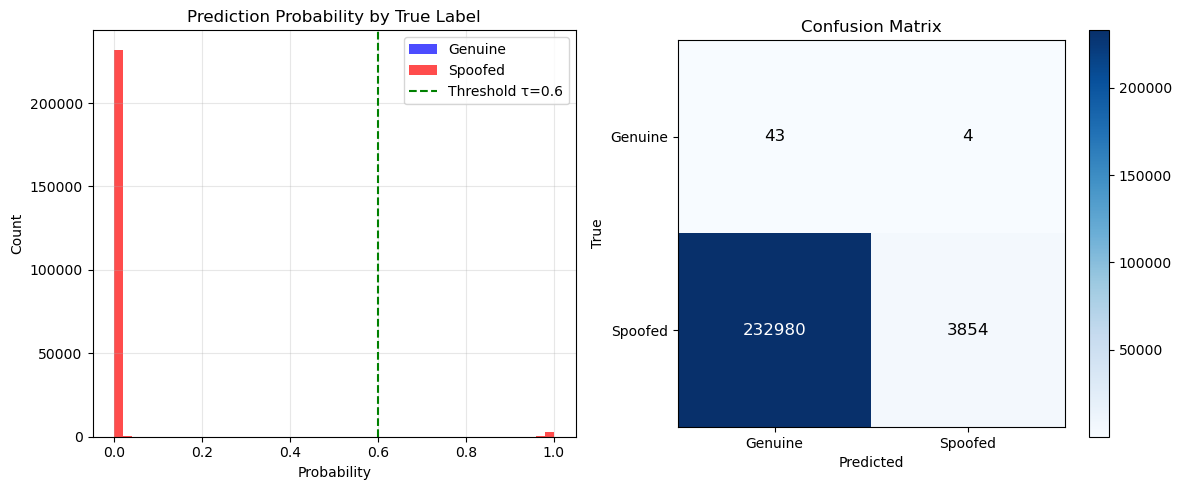

Saved plots to dataset\models\population_eval_plots.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Score distributions
axes[0].hist(y_test_probs[y_test == 0], bins=50, alpha=0.7, label='Genuine', color='blue')
axes[0].hist(y_test_probs[y_test == 1], bins=50, alpha=0.7, label='Spoofed', color='red')
axes[0].axvline(THRESHOLD, color='green', linestyle='--', label=f'Threshold τ={THRESHOLD}')
axes[0].set_title('Prediction Probability by True Label')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_test_pred)
im = axes[1].imshow(cm, cmap='Blues')
axes[1].set_xticks([0,1]); axes[1].set_yticks([0,1])
axes[1].set_xticklabels(['Genuine','Spoofed']); axes[1].set_yticklabels(['Genuine','Spoofed'])
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j] > cm.max()/2 else 'black', fontsize=12)
axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
fig.colorbar(im, ax=axes[1])

plt.tight_layout()
fig_path = output_root / 'population_eval_plots.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved plots to {fig_path}")

## 7. Save Evaluation Metrics and Figures
Persist computed metrics and generated visualizations for reporting.

In [ ]:
# Save single-trajectory results
single_traj_df = pd.DataFrame([
    {
        'type': name,
        'mean_prob': float(mean_p),
        'max_prob': float(max_p),
        'detection_rate_percent': float(rate)
    }
    for name, mean_p, max_p, rate, _ in results
])
# single_traj_path = output_root / 'single_traj_eval.csv'
# single_traj_df.to_csv(single_traj_path, index=False)
# print(f"Saved single-trajectory results to {single_traj_path}")

# Metrics already saved to population_eval_summary.json and plots saved
# print(f"Summary JSON: {summary_path}")
# print(f"Population plots: {fig_path}")

: 